# OHBM 2020 - Open Science Room - Neurolang

## Synonyms

### Background
While recent advances in automated meta-analysis techniques, like NeuroSynth[1], address long-standing inferential problems in the neuroimaging literature, they still present many challenges for cognitive neuroscientists, and some limitations remain to be addressed. Neurosynth[1], for example, is based on a purely lexical coding approach that does not allow for the distinction between different terms with similar meanings (e.g. `pain`, `nociception}`, and `noxious}`) and does not allow closely related constructs to be easily distinguished (e.g. `physical pain` vs. `emotional pain`)[2].

### Our approach
We believe that the hierarchical structure of information provided by ontologies is ideally suited to tackle this type of problems. Ontologies are a formal way of representing knowledge in which concepts are described both by their meaning and their relationship to each other[3].

We propose then a possible solution to this issue, taking advantage of the relationships between entities that ontologies provide us, unifying different terms that have the same meaning. They allow us to use related terms without having to know them in advance. We will show how through this improvement we can enhance meta-analysis techniques, by using results derived from the combination of our initial tag and the information defined in ontologies.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import stats_helper, datasets_helper
from neurolang.frontend.ontology_frontend import NeurolangOntologyDL
from rdflib import RDFS
from nilearn import plotting
from matplotlib import pyplot as plt
from operator import eq
from neurolang.expressions import Constant, Symbol
import numpy as np
import nibabel as nib


Bad key "text.kerning_factor" on line 4 in
/Users/gzanitti/miniconda3/envs/ontologies_paper/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


We use Neurolang to process the IOBC ontology. We are using the information provided by the ontology, to look for all the terms (and their alternative names) related to the class of biostimuli (We use the URI of this class for a matter of simplicity). 

The pain string included inside the symbol acts as a filter. This way, our query only returns those values where `label(x, 'Pain')` is true. Then we will use this information to perform a search in the NeuroSynth database.

In [3]:
nl = NeurolangOntologyDL()
datasets_helper.load_pain_datasets(nl)

paths = ['neurolang_data/ontologies/IOBC_1_4_0.xrdf']
nl.load_ontology(paths)

In [4]:
label = nl.new_symbol(name=str(RDFS.label))
related = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#related')
altLabel = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#altLabel')
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))

@nl.add_symbol
def first_word(name: str) -> str:
    return name.split(" ")[0]

with nl.environment as e:
    e.related_biostimulation_terms[e.word] = (e.word == 'pain')
    
    e.related_biostimulation_terms[e.alternative_names] = (
        subclass_of(e.biostimulation_subclass, 'http://purl.jp/bio/4/id/200906066643737725') &
        label(e.pain_entity, 'Pain') & 
        related(e.pain_entity, e.biostimulation_subclass) &
        altLabel(e.biostimulation_subclass, e.alternative_names)
    )
    e.synonyms[e.short_name] = (
        (e.short_name == nl.symbols.first_word(e.alternative_names)) & 
        e.related_biostimulation_terms(e.alternative_names)
    )

Where each entry corresponds to its equivalent in first order logic, respecting the order:


$(\forall word)$ <br/>
$(related\_biostimulation\_terms(word) \leftarrow (\exists word) (
    word \text{==} \text{'pain'}
))$

$(\forall alternative\_names)$ <br/>
$(related\_biostimulation\_terms(alternative\_names) \leftarrow (\exists biostimulation\_subclass, pain\_entity)$ <br/>
$(
    subclass_of(biostimulation\_subclass, \text{'http://purl.jp/bio/4/id/200906066643737725'}) \wedge $<br/>
    $ label(pain\_entity, \text{'Pain'}) \wedge$ <br/>
    $ related(pain\_entity, biostimulation\_subclass) \wedge$ <br/>
    $ altLabel(biostimulation\_subclass, alternative\_names) 
))$

$(\forall short\_name)$ <br/>
$(synonyms(short\_name) \leftarrow (\exists alternative\_names)$<br/> 
$(
    short\_name \text{==} first\_word(alternative\_names) \wedge $ <br/>
    $ related\_biostimulation\_terms(alternative\_names)
))$

The fact of having obtained the synonyms of the term `pain` directly from the ontology, allows us to avoid having to declare each of the terms to be evaluated and to be able to obtain this information directly from `e.synonyms(e.term)` without the need to know it beforehand.

In [5]:
with nl.environment as e:    
    e.act_term[e.term, e.voxid] = (
        e.synonyms(e.term) &
        e.ns_tfidf_pmid_term[e.tfidf, e.pmid, e.term] &
        e.ns_activations_by_id[e.pmid, e.voxid] &
        (e.tfidf > 1e-3)
    )
 
    e.xyz_given_term[e.voxid, e.x, e.y, e.z, e.term] = (
        e.act_term[e.term, e.voxid] &
        e.ns_vox_id_MNI[e.voxid, e.x, e.y, e.z]
    )

With its expression of first order logic given by:

$(\forall voxels\_ns)$ <br/>
$(probability\_voxel(voxels\_ns) \leftarrow (\exists term, region\_ns)$ <br/>
$(
    neurosynth\_data(term, region\_ns) \wedge$ <br/>
    $synonyms(term) \wedge$ <br/>
    $neurosynth\_region(region\_ns, voxels\_ns)
))$

In [6]:
result = nl.solve_query()

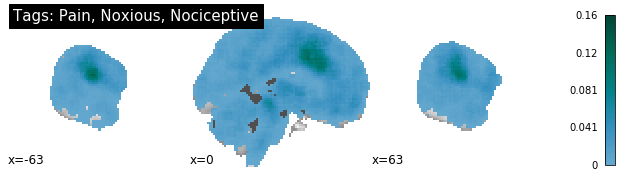

In [6]:
result_data = result.value.to_numpy()
prob_terms = aux.load_neurosynth_pain_prob_terms()

prob_img = nib.spatialimages.SpatialImage(
    np.zeros(result_data[0][1].image_dim, dtype=float),
    affine=result_data[0][1].affine
)

for p in result_data:
    prob_img.dataobj[tuple(p[1].voxels.T)] = p[0]/prob_terms[prob_terms['index'] == p[4]]['proba'].values[0]

plotting.plot_stat_map(
    prob_img, 
    title='Tags: Pain, Noxious, Nociceptive', 
    cmap='PuBuGn',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 3),
)

Now we can analyze the results by plotting the p-values obtained

In [14]:
res, p_values_corrected, p_value_image = stats_helper.compute_p_values(prob_img, q=1e-2, n=100)

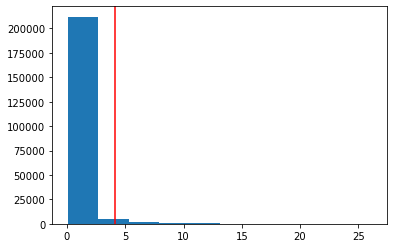

In [15]:
plt.hist(-np.log10(res))
plt.axvline(-np.log10(p_values_corrected), c='r')

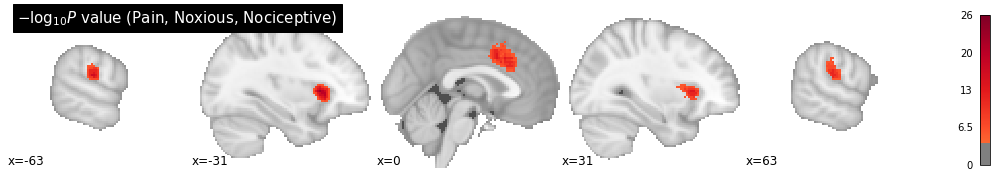

In [16]:
plotting.plot_stat_map(
    p_value_image, 
    title=r'$-\log_{10} P$ value (Pain, Noxious, Nociceptive)', 
    threshold=-np.log10(p_values_corrected), 
    cmap='YlOrRd',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 5),
)

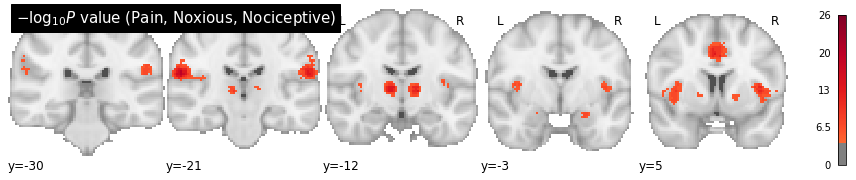

In [17]:
plotting.plot_stat_map(
    p_value_image, title=r'$-\log_{10} P$ value (Pain, Noxious, Nociceptive)', 
    threshold=-np.log10(p_values_corrected),
    cmap='YlOrRd',
    display_mode='y',
    cut_coords=np.linspace(-30, 5, 5),
)

This example is a first demonstration of how, using the hierarchical information provided by ontologies, we are able to obtain results enriched with information from heterogeneous sources.

We obtained a combination of results from the NeuroSynth database, without the need to know all the synonyms available for the term `pain`, and avoiding having to iterate for each one of them.


#### References
[1] Yarkoni, T.: Neurosynth core tools v0.3.1, DOI: 10.5281/zenodo.9925 (2014). <br/>
[2] Yarkoni, T., Poldrack, R. A., Nichols, T. E., Van Essen, D. C. & Wager, T. D: Large-scale automated synthesis of human functional neuroimaging data. Nat. Methods 8, 665–670, DOI: 10.1038/nmeth.1635 (2011). <br/>
[3] Bard, J.B.L., Rhee, S.Y.: Ontologies in biology: design, applications and future challenges. Nature Reviews   Genetics5(3), 213–222 (Mar   2004). https://doi.org/10.1038/nrg1295, https://www.nature.com/articles/nrg1295
[4] Bienvenu, M.: Ontology-Mediated Query Answering: Harnessing Knowledge to GetMore From Data, p. 4 <br/>
[5] Cali, A., Gottlob, G., Lukasiewicz, T.: A general Datalog-based framework for tractable query answering over ontologies. Journal of Web Semantics 14, 57–83 (Jul 2012). https://doi.org/10.1016/j.websem.2012.03.001, http://www.sciencedirect.com/science/article/pii/S1570826812000388 <br/>
[6] Cali, A., Gottlob, G., Pieris, A.:Towards more expressive ontology languages: The query answering problem. Artificial Intelligence 193, 87-128 (Dec2012). https://doi.org/10.1016/j.artint.2012.08.002,http://www.sciencedirect.com/science/article/pii/S0004370212001026 <br/>
[7] Gottlob, G., Orsi, G., Pieris, A.: Query Rewriting and Optimization for Ontological Databases. ACM Transactions  on Database Systems 39 (May 2014). https://doi.org/10.1145/2638546 <br/>